In [1]:
import os
import pandas as pd
from pyspark.ml.feature import StringIndexer, OneHotEncoder
import plotly.express as px
import json

os.chdir('../')


In [2]:

from Utils.SparkSessionManager import SparkSessionManager
from Service.DataReader import DataReader
from Service.VMAnalyzer import VMAnalyzer

In [3]:
spark = SparkSessionManager.create_session()
dt_reader = DataReader(spark)
with open('settings.json', 'r') as file:
    data = json.load(file)

local_settings = data['Local']
filepath = local_settings['filepath']
input_file = local_settings['input']

csv_file, vmSchema = dt_reader.read_data(filepath, input_file)
dt_analyzer = VMAnalyzer(spark, csv_file, vmSchema)


In [4]:
dataFrame = dt_analyzer.get_df()
processed_df = dt_analyzer.pre_processing_pipeline()

In [5]:
columns = ["baseScore", "impactScore", "exploitabilityScore"]
dt_analyzer.calculate_range(dataFrame, columns)

+-------------+-------------+---------------+---------------+-----------------------+-----------------------+
|min_baseScore|max_baseScore|min_impactScore|max_impactScore|min_exploitabilityScore|max_exploitabilityScore|
+-------------+-------------+---------------+---------------+-----------------------+-----------------------+
|          2.1|         10.0|            1.4|            6.0|                    0.2|                    3.9|
+-------------+-------------+---------------+---------------+-----------------------+-----------------------+



+----+------------------+
|Year|        Base Score|
+----+------------------+
|2011|               7.5|
|2012| 5.925000190734863|
|2013| 6.920000171661377|
|2014|               6.8|
|2015|7.6238096214476085|
|2016| 7.256000061035156|
|2017| 7.692817796001118|
|2018|7.4189874311036705|
|2019| 7.172727346420288|
|2020|   7.0690729423864|
|2021| 7.066640901047653|
+----+------------------+



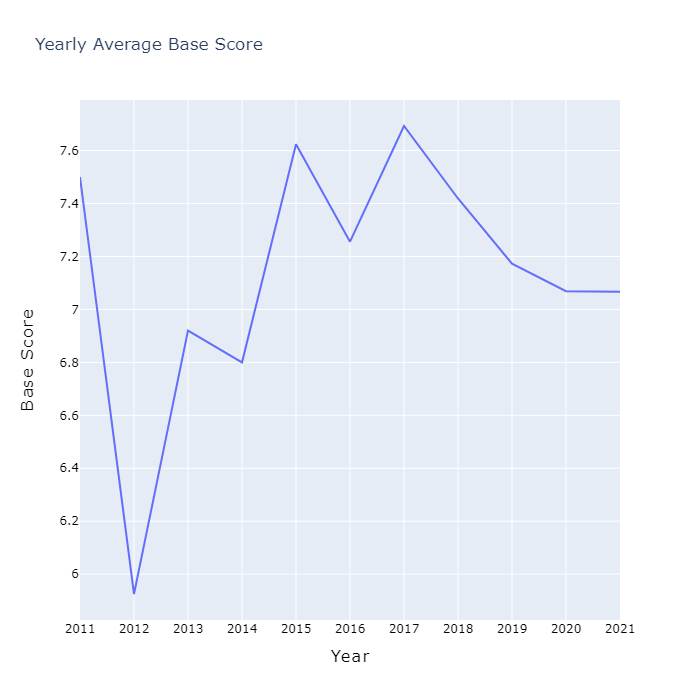

In [6]:
mean_df_base_score = dt_analyzer.calculate_mean_category(dataFrame, "year", "baseScore", "Year", "Base Score", True)
options = {
    'xAxisLabel': "<span style='letter-spacing: 1.3px;'>Year</span>",
    'yAxisLabel': "<span style='letter-spacing: 1.3px;'>Base Score</span>",
    'width': 700,
    'height': 700,
    'title': "Yearly Average Base Score",
    'format': "png",
    'font_size': 16,
    'font_color': "black",
    'value_color': "black",
    'value_size': 12
}
dt_analyzer.show_line_chart(mean_df_base_score, "Year", "Base Score", options)

+----------------+----------+
|   Attack Vector|Base Score|
+----------------+----------+
|           LOCAL|       7.8|
|         NETWORK|       7.5|
|        PHYSICAL|       6.8|
|ADJACENT NETWORK|       8.8|
+----------------+----------+

+----------------+------------------+
|   Attack Vector|        Base Score|
+----------------+------------------+
|           LOCAL|  6.64129519082938|
|         NETWORK| 7.353532108513199|
|        PHYSICAL| 5.635227303613316|
|ADJACENT NETWORK|7.1443182826042175|
+----------------+------------------+



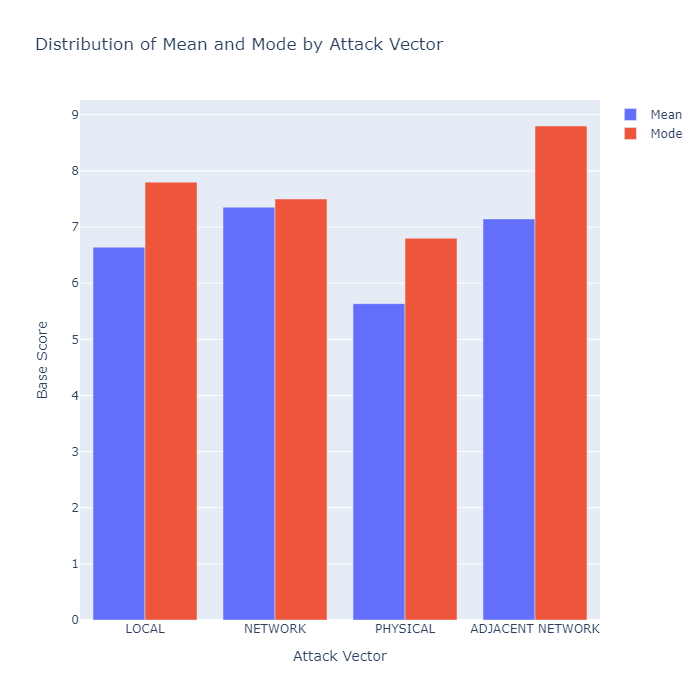

In [7]:

mode_df_base_score = dt_analyzer.calculate_mode_category(dataFrame, "attackVector", "baseScore", "Attack Vector", "Base Score")
mean_df_base_score = dt_analyzer.calculate_mean_category(dataFrame, "attackVector", "baseScore", "Attack Vector", "Base Score")
options = {
    'xAxisLabel': "<span style='letter-spacing: 1.3px;'>Attack Vector</span>",
    'yAxisLabel': "<span style='letter-spacing: 1.3px;'>Base Score</span>",
    'width': 700,
    'height': 700,
    'title': "Distribution of Mean and Mode by Attack Vector",
    'format': "png",
    'font_size': 16,
    'font_color': "black",
    'value_color': "black",
    'value_size': 12
}
dt_analyzer.show_go_bar_chart_mean_mode(mode_df_base_score, mean_df_base_score, "Attack Vector", "Base Score", options)



The above results indicate that there is a higher distribution of vulnerabilites with higher severity from adjacent network. <br>
Thus for this sample the distribution is negatively skewed since the mode is greater than the mean

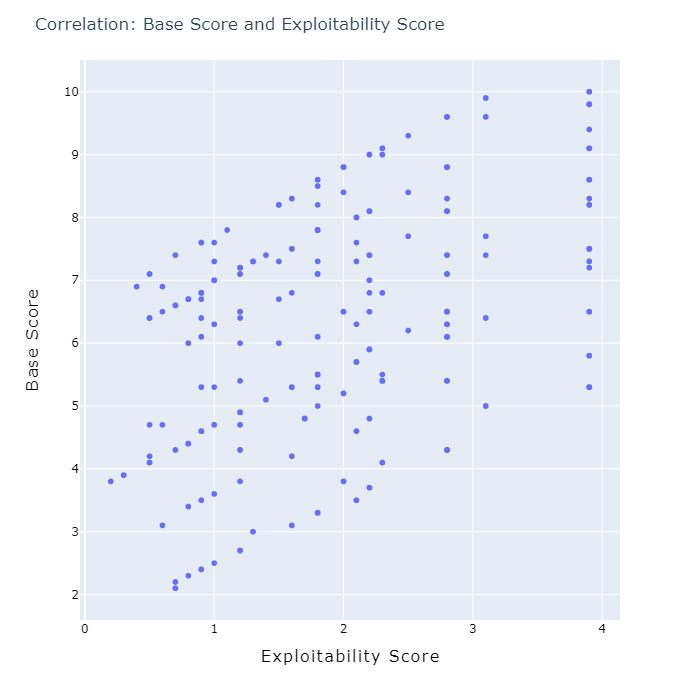

In [8]:
options = {
    'xAxis': "<span style='letter-spacing: 1.3px;'>Exploitability Score</span>",
    'yAxis': "<span style='letter-spacing: 1.3px;'>Base Score</span>",
    'width': 700,
    'height': 700,
    'title': "Correlation: Base Score and Exploitability Score",
    'format': "png",
    'font_size': 16,
    'font_color': "black",
}
dt_analyzer.show_correlation_scatter_plot(processed_df, "exploitabilityScore", "baseScore", options)

The above scatter plot indicates a low positive correlation between exploitability score and base score.<br>
Vulnerabilites with a higher exploitability and base score would effectively increase the overall CVSS score

+----------------+------------+-----+
|    attackVector|baseSeverity|count|
+----------------+------------+-----+
|ADJACENT_NETWORK|    CRITICAL|    1|
|         NETWORK|         LOW|   23|
|           LOCAL|        HIGH|  509|
|ADJACENT_NETWORK|        HIGH|   41|
|        PHYSICAL|         LOW|    9|
|           LOCAL|         LOW|   50|
|        PHYSICAL|      MEDIUM|   72|
|         NETWORK|        HIGH| 1079|
|         NETWORK|      MEDIUM| 1076|
|ADJACENT_NETWORK|         LOW|    2|
|         NETWORK|    CRITICAL|  540|
|           LOCAL|    CRITICAL|    1|
|           LOCAL|      MEDIUM|  382|
|        PHYSICAL|        HIGH|    7|
|ADJACENT_NETWORK|      MEDIUM|   44|
+----------------+------------+-----+



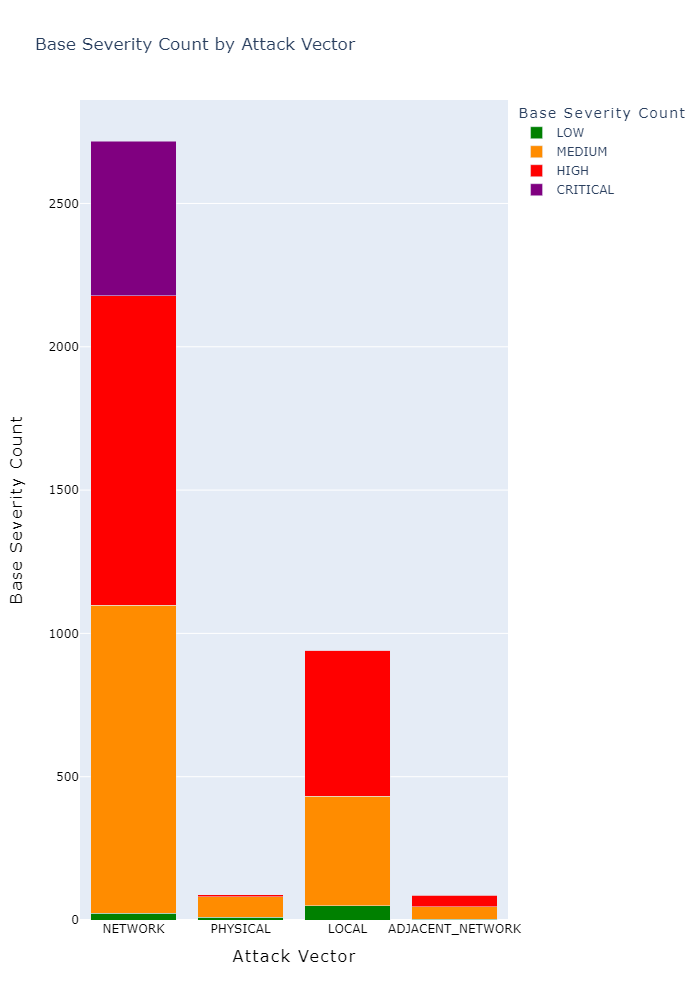

In [9]:
options = {
    'xAxisLabel': "<span style='letter-spacing: 1.3px;'>Attack Vector</span>",
    'yAxisLabel': "<span style='letter-spacing: 1.3px;'>Base Severity Count</span>",
    'width': 700,
    'height': 1000,
    'title': "Base Severity Count by Attack Vector",
    'format': "png",
    'font_size': 16,
    'font_color': "black",
    'value_color': "black",
    'value_size': 12
}
dt_analyzer.show_correlation_stacked_bar_chart(processed_df, "attackVector", "baseSeverity", options)

For this sample, it can be observed that Network is the only attack vector having the most vulnerabilities with critical severity. <br>
In conclusion, Network is the most viable exploitable vector through which higher severity attacks can affect a system

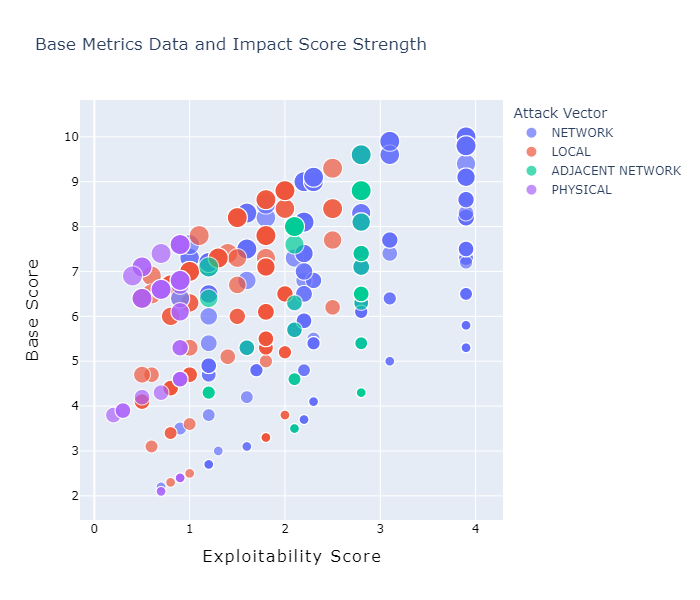

In [10]:
options = {
    'xAxisLabel': "<span style='letter-spacing: 1.3px;'>Exploitability Score</span>",
    'yAxisLabel': "<span style='letter-spacing: 1.3px;'>Base Score</span>",
    'width': 700,
    'height': 600,
    'title': "Base Metrics Data and Impact Score Strength",
    'format': "png",
    'font_size': 16,
    'font_color': "black",
    'value_color': "black",
    'value_size': 12,
     'size_col': "impactScore",
     'color_col': "attackVector",
     'key_label': "Attack Vector"
}
dt_analyzer.show_bubble_chart(
   processed_df, 
  "exploitabilityScore",
  "baseScore", 
   options
  )

The bubble chart above illustrates a low positive correlation between exploitability score and base score. <br>
However, an additional metric - Impact Score, has been introduced for extra dimensionality. <br>
Thus the size of the bubbles represent the value of the Impact Score giving an indication of which attack vector has the greatest exploit in a worse case scenario

0.7572366837482335
Correlation matrix:
                        Confidentiality Impact  Integrity Impact  \
Confidentiality Impact                1.000000          0.757237   
Integrity Impact                      0.757237          1.000000   
Availability Impact                   0.497927          0.606729   

                        Availability Impact  
Confidentiality Impact             0.497927  
Integrity Impact                   0.606729  
Availability Impact                1.000000  


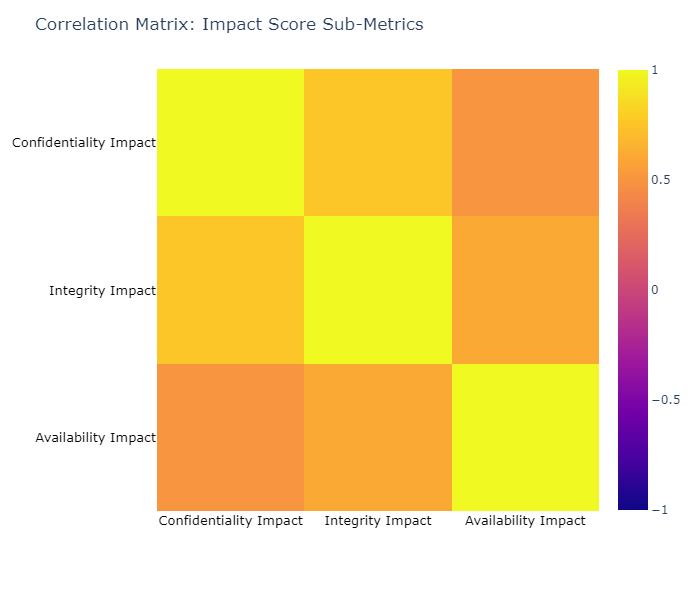

In [11]:
dt_analyzer.check_correlation(processed_df, "ConfidentialityImpactNumeric", "IntegrityImpactNumeric")
column_display_info = [
    {"column_name": "ConfidentialityImpactNumeric", "display_name": "Confidentiality Impact"},
    {"column_name": "IntegrityImpactNumeric", "display_name": "Integrity Impact"},
    {"column_name": "AvailabilityImpactNumeric", "display_name": "Availability Impact"}
]
correlation_df = dt_analyzer.calculate_correlation(processed_df, column_display_info)
options = {
    'width': 700,
    'height': 600,
    'title': "Correlation Matrix: Impact Score Sub-Metrics",
    'format': "png",
    'font_size': 16,
    'font_color': "black",
    'value_color': "black",
    'value_size': 13,
}
dt_analyzer.show_heatmap(correlation_df, options)

The above results indicate a low to strong positive correlation between Availability Impact, Confidentiality Impact and Integrity Impact. <br>
These scores are sub metrics used to calculate impact score, thus it can be indeed deduced that a slight increase in the sub metrics will affect the overall impact score. <br> 

In [12]:
columns_clustering = ['baseScore', 'exploitabilityScore', 'impactScore']
dt_analyzer.clustering_pipeline(processed_df, columns_clustering)

Silhouette Score: 0.5954636946770762
Silhouette Score: 0.5639652768404092
Silhouette Score: 0.6447270409087427
Silhouette Score: 0.6824416031017678
Silhouette Score: 0.7289558929703163
Silhouette Score: 0.6571492398842727
Within Set Sum of Squared Errors (WSSSE) = 0.6571492398842727
